In [1]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src
sys.path.insert(1, os.path.join(sys.path[0], '../'))  # for importing model config

%reload_ext autoreload
%autoreload 2 

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{gensymb} \usepackage{siunitx}'
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 12

## Loading predictions

In [2]:
cn_pred = pd.read_csv('results_cnwheat_input_phys_predictions.csv', index_col=0)
hs_pred = pd.read_csv('results_hydroshoot_input_phys_predictions.csv', index_col=0)

In [3]:
hs_pred.head()

,input_Rg__true,input_Rg__state_Tlc,input_Rg__state_E,input_Rg__state_gs,output_Rg__true,output_Rg__state_Tlc,output_Rg__state_E,output_Rg__state_gs,output_An__true,output_An__state_Tlc,output_An__state_E,output_An__state_gs,input_Rg_NARMA_8__true,input_Rg_NARMA_8__state_Tlc,input_Rg_NARMA_8__state_E,input_Rg_NARMA_8__state_gs
0,-1.257627,-0.750853,-0.893200,-0.844656,-1.352480,-0.641399,-0.868592,-0.841067,-1.623972,-0.398986,-0.820100,-0.932815,-1.010816,-1.164342,-1.001314,-0.926297
1,-0.797091,-0.382883,-0.502288,-0.094382,-0.803670,-0.260185,-0.454168,-0.058702,0.133483,0.158753,-0.318825,0.074812,-1.010569,-0.622902,-0.706530,-0.522872
2,-0.189663,0.177390,-0.236109,0.018481,0.188815,0.481573,-0.138565,0.112869,0.739803,1.038819,-0.336222,0.217998,-0.990968,-0.250951,-0.559216,-0.155355
3,0.376191,1.100382,1.077729,0.909306,0.937627,1.357517,1.226575,0.927654,0.972980,1.092478,0.728658,0.851560,-0.884301,0.001094,-0.018333,0.461179
4,0.877199,1.364241,1.352049,1.057987,1.222997,1.477510,1.560373,1.203853,0.875595,0.936855,0.915340,0.680559,-0.632007,0.105235,-0.122555,-0.140343


In [4]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [5]:

from sklearn.metrics import mean_squared_error

def nmse(y_true, y_pred, epsilon=1e-12):
    score = mean_squared_error(y_true, y_pred) / (y_true.var() + epsilon)
    return score

## Figures

### Accuracy plots (no time)

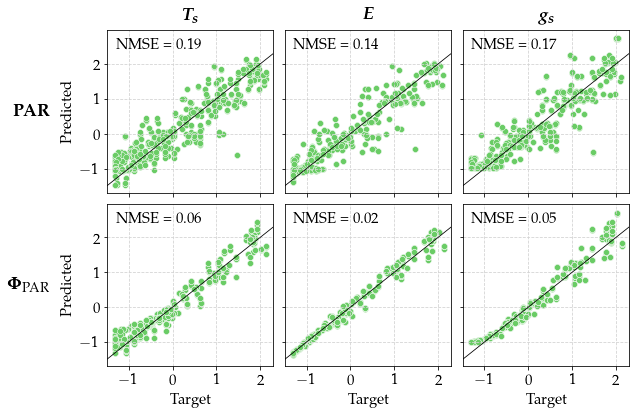

In [6]:
targets = 'input_PARi', 'output__custom__PARa'
reservoirs = 'state__Ts', 'state__Tr', 'state__gs'

target_symbols = {
  'input_PARi': r'\textbf{PAR}',
  # 'input_PARi': r'$I_{\text{PAR}}$',
  'output__custom__PARa': r'$\boldsymbol{\Phi_{\text{PAR}}}$',
  # 'output__custom__PARa': r'$\Phi_{I_{\text{PAR}}}$',
}
# target_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in target_symbols.items()}

reservoir_symbols = {
  'state__Ts': r"$T_s$",
  'state__Tr': r"$E$",
  'state__gs': r"$g_s$",
}
reservoir_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in reservoir_symbols.items()}



with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(2, 3, figsize=(9, 6), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0, 1], axs, targets):
    for col, ax, reservoir in zip([0, 1, 2], axs_row, reservoirs):
      # Data
      score = nmse(cn_pred[f'{target}__true'], cn_pred[f'{target}__{reservoir}'])
      sns.scatterplot(data=cn_pred, x=f'{target}__true', y=f'{target}__{reservoir}', color=colors[1], ax=ax)
      
      # Axes
      add_identity(ax, color='black', linestyle='solid', linewidth=0.8)
      ax.set_xticks([-1, 0, 1, 2])
      ax.grid(axis='both', color='lightgrey', linestyle='dashed')

      
      # Labeling
      ax.set_xlabel('Target')
      ax.set_ylabel('Predicted')
      if col == 0:
        ax.annotate(target_symbols[target], (-0.35, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=18)
      if row == 0:
        ax.annotate(reservoir_symbols[reservoir], (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)
      ax.annotate(f'NMSE = {score:.2f}', (0.05, 0.95), xycoords='axes fraction', va='top')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.07, hspace=0.07)  
  plt.savefig('regression_res_accuracy_cnwheat.png', dpi=200, facecolor='white', bbox_inches='tight')

  

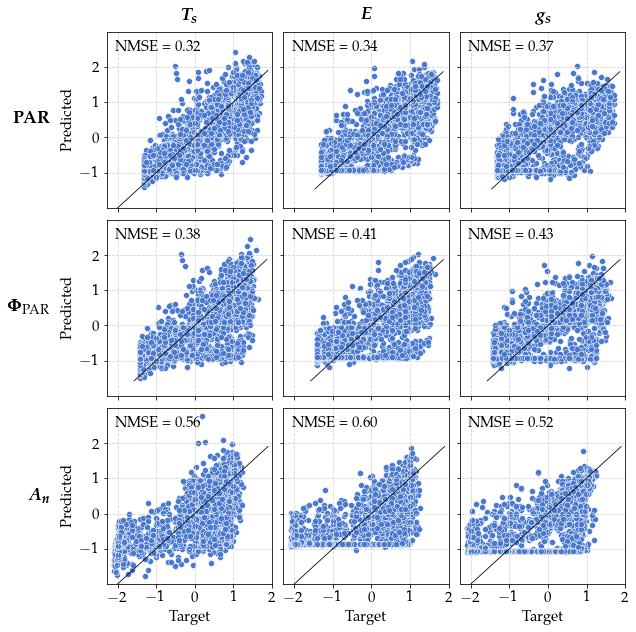

In [7]:
hs_targets = ['input_Rg', 'output_Rg', 'output_An']
hs_reservoirs = ['state_Tlc', 'state_E', 'state_gs']

target_symbols = {
  'input_Rg': r'\textbf{PAR}',
  'output_Rg': r'$\boldsymbol{\Phi_{\text{PAR}}}$',
  'output_An': r'$\boldsymbol{A_n}$',
}
# target_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in target_symbols.items()}

reservoir_symbols = {
  'state_Tlc': r"$T_s$",
  'state_E': r"$E$",
  'state_gs': r"$g_s$",
}
reservoir_symbols = {k: f'$\\boldsymbol{{{v[1:-1]}}}$' for k, v in reservoir_symbols.items()}

with plt.style.context('seaborn-muted'):
  fig, axs = plt.subplots(3, 3, figsize=(9, 9), sharey=True, sharex=True)
  colors = sns.color_palette()

  for row, axs_row, target in zip([0, 1, 2], axs, hs_targets):
    for col, ax, reservoir in zip([0, 1, 2], axs_row, hs_reservoirs):
      # Data
      score = nmse(hs_pred[f'{target}__true'], hs_pred[f'{target}__{reservoir}'])
      sns.scatterplot(data=hs_pred, x=f'{target}__true', y=f'{target}__{reservoir}', color=colors[0], ax=ax)
      
      # Axes
      add_identity(ax, color='black', linestyle='solid', linewidth=0.8)
      ax.set_xticks([-2, -1, 0, 1, 2])
      ax.grid(axis='both', color='lightgrey', linestyle='dashed')
      
      # Labeling
      ax.set_xlabel('Target')
      ax.set_ylabel('Predicted')
      if col == 0:
        ax.annotate(target_symbols[target], (-0.35, 0.5), xycoords='axes fraction', va='center', ha='right', fontsize=18)
      if row == 0:
        ax.annotate(reservoir_symbols[reservoir], (0.5, 1.07), xycoords='axes fraction', ha='center', fontsize=18)
      ax.annotate(f'NMSE = {score:.2f}', (0.05, 0.95), xycoords='axes fraction', va='top')

  plt.tight_layout()
  plt.subplots_adjust(wspace=0.07, hspace=0.07)  
  plt.savefig('regression_res_accuracy_hydroshoot.png', dpi=200, facecolor='white', bbox_inches='tight')

  

### Prediction plots (time)

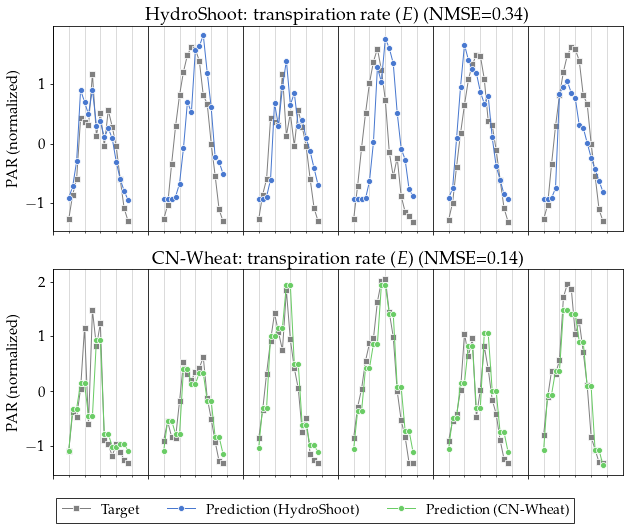

In [8]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, FixedFormatter, FixedLocator)

cn_target = 'input_PARi'
hs_target = 'input_Rg'

cn_reservoir = 'state__Tr'
hs_reservoir = 'state_E'

hs_score = nmse(hs_pred[f'{hs_target}__true'], hs_pred[f'{hs_target}__{hs_reservoir}'])
cn_score = nmse(cn_pred[f'{cn_target}__true'], cn_pred[f'{cn_target}__{cn_reservoir}'])

with plt.style.context('seaborn-muted'):
  # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 9))
  fig = plt.figure(1, figsize=(9, 7))
  colors = sns.color_palette()
  N_SAMPLES = 6


  ### HYDROSHOOT ###
  ax = plt.subplot(211)
  OFFSET = 43
  PAD_L = 4
  PAD_R = 4
  sample_width = 16 + PAD_R + PAD_L
  width = N_SAMPLES * sample_width
  # data
  time = np.arange(0, width)

  for i_sample in range(N_SAMPLES):
    start = (OFFSET + i_sample) * 16
    end = start + 16
    plot_data = hs_pred.iloc[start:end]
    
    time_start = (i_sample - 1) * (PAD_R + 16) + i_sample * PAD_L 
    time_end = time_start + 16
    plot_time = time[time_start:time_end]

    if i_sample == 0:
      sns.lineplot(data=plot_data, x=plot_time, y=f'{hs_target}__true', color='grey', linewidth=1, ax=ax, marker='s', label='Target')
      sns.lineplot(data=plot_data, x=plot_time, y=f'{hs_target}__{hs_reservoir}', color=colors[0], linewidth=1, ax=ax, marker='o', label='Prediction (HydroShoot)')
    else:
      sns.lineplot(data=plot_data, x=plot_time, y=f'{hs_target}__true', color='grey', linewidth=1, ax=ax, marker='s')
      sns.lineplot(data=plot_data, x=plot_time, y=f'{hs_target}__{hs_reservoir}', color=colors[0], linewidth=1, ax=ax, marker='o')
  
  # axes
  ax.xaxis.set_major_locator(FixedLocator(time[::sample_width]))
  ax.xaxis.set_minor_locator(FixedLocator(time[::4]))
  ax.xaxis.set_major_formatter(FixedFormatter(['' * len(time[::sample_width])]))
  ax.set_axisbelow(True)
  ax.grid(axis='x', color='black', linewidth=0.8, which='major')
  ax.grid(axis='x', color='lightgrey', linewidth=0.8, which='minor')
  ax.set_xlim(0, width)

  # labels
  ax.set_ylabel(r'PAR (normalized)')
  ax.set_title(f'HydroShoot: transpiration rate ($E$) (NMSE={hs_score:.2f})')

  # cleanup
  ax.get_legend().remove()

  ###  CN-WHEAT  ###
  ax = plt.subplot(212)
  OFFSET = 16
  PAD_L = 4
  PAD_R = 4
  sample_width = 16 + PAD_R + PAD_L
  width = N_SAMPLES * sample_width
  # data
  time = np.arange(0, width)

  for i_sample in range(N_SAMPLES):
    start = (OFFSET + i_sample) * 16
    end = start + 16
    plot_data = cn_pred.iloc[start:end]
    
    time_start = (i_sample - 1) * (PAD_R + 16) + i_sample * PAD_L 
    time_end = time_start + 16
    plot_time = time[time_start:time_end]


    sns.lineplot(data=plot_data, x=plot_time, y=f'{cn_target}__true', color='grey', linewidth=1, ax=ax, marker='s')
    if i_sample == 0:
      sns.lineplot(data=plot_data, x=plot_time, y=f'{cn_target}__{cn_reservoir}', color=colors[1], linewidth=1, ax=ax, marker='o', label='Prediction (CN-Wheat)')
    else:
      sns.lineplot(data=plot_data, x=plot_time, y=f'{cn_target}__{cn_reservoir}', color=colors[1], linewidth=1, ax=ax, marker='o')
  
  # axes
  ax.xaxis.set_major_locator(FixedLocator(time[::sample_width]))
  ax.xaxis.set_minor_locator(FixedLocator(time[::4]))
  ax.xaxis.set_major_formatter(FixedFormatter(['' * len(time[::sample_width])]))
  ax.set_axisbelow(True)
  ax.grid(axis='x', color='black', linewidth=0.8, which='major')
  ax.grid(axis='x', color='lightgrey', linewidth=0.8, which='minor')
  ax.set_xlim(0, width)

  # labels
  ax.set_ylabel(r'PAR (normalized)')
  ax.set_title(f'CN-Wheat: transpiration rate ($E$) (NMSE={cn_score:.2f})')

  # cleanup
  ax.get_legend().remove()

  ### FINAL FIGURE ###
  fig.legend(loc='lower center', fancybox=False, shadow=False, ncol=5, 
                 frameon=True, edgecolor='black', bbox_to_anchor=(0.5, -0.07), fontsize=14)
  plt.tight_layout()
  plt.savefig('regression_res_prediction.png', dpi=200, facecolor='white', bbox_inches='tight')

### Hybrid plots

In [11]:
hs_pred.columns

Index(['input_Rg__true', 'input_Rg__state_Tlc', 'input_Rg__state_E',
       'input_Rg__state_gs', 'output_Rg__true', 'output_Rg__state_Tlc',
       'output_Rg__state_E', 'output_Rg__state_gs', 'output_An__true',
       'output_An__state_Tlc', 'output_An__state_E', 'output_An__state_gs',
       'input_Rg_NARMA_8__true', 'input_Rg_NARMA_8__state_Tlc',
       'input_Rg_NARMA_8__state_E', 'input_Rg_NARMA_8__state_gs'],
      dtype='object')

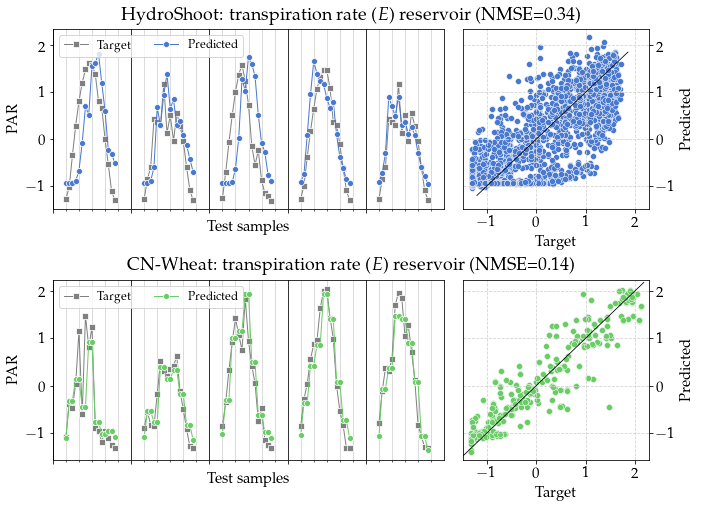

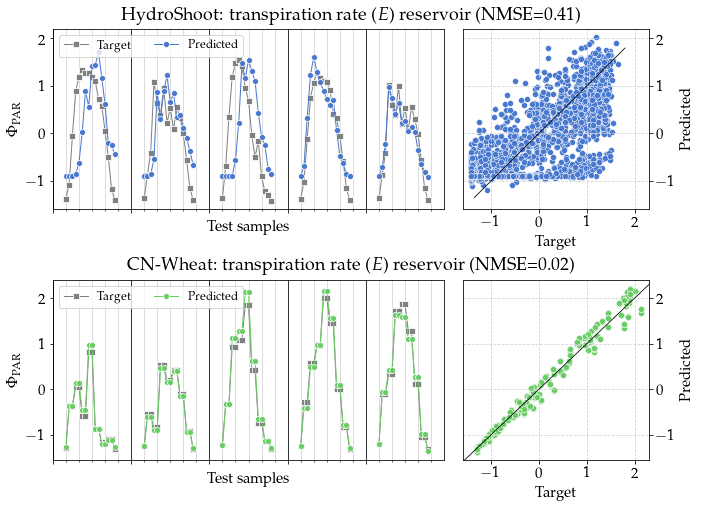

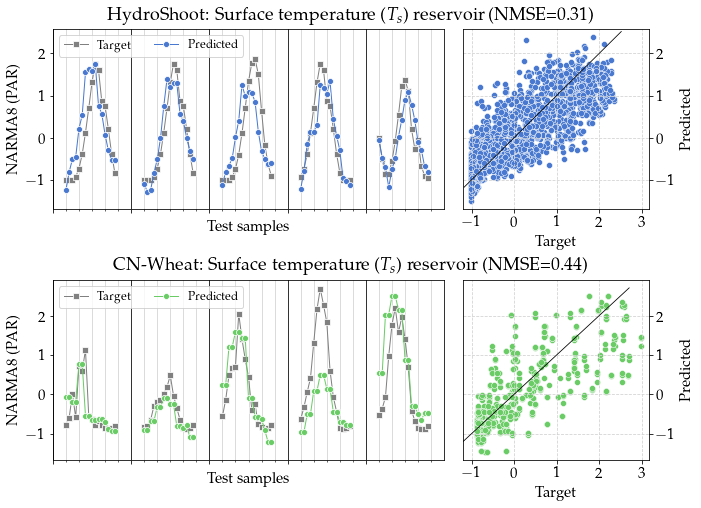

In [115]:
from matplotlib.gridspec import GridSpec


cn_combis = [
  ('input_PARi', 'state__Tr'),
  ('output__custom__PARa', 'state__Tr'),
  ('input_PARi_NARMA_8', 'state__Ts')
]

hs_combis = [
  ('input_Rg', 'state_E'),
  ('output_Rg', 'state_E'),
  ('input_Rg_NARMA_8', 'state_Tlc')
]

res_names = [
  r'transpiration rate ($E$) reservoir',
  r'transpiration rate ($E$) reservoir',
  r'Surface temperature ($T_s$) reservoir',
]

target_names = [
  r'PAR',
  r'$\Phi_{\text{PAR}}$',
  r'NARMA8 (PAR)',
]

for i_plot in range(3):
  (cn_target, cn_res) = cn_combis[i_plot]
  (hs_target, hs_res) = hs_combis[i_plot]

  hs_true = hs_pred[f'{hs_target}__true']
  hs_true = hs_true[~np.isnan(hs_true)]
  hs_res_pred = hs_pred[f'{hs_target}__{hs_res}']
  hs_res_pred = hs_res_pred[~np.isnan(hs_res_pred)]

  cn_true = cn_pred[f'{cn_target}__true']
  cn_true = cn_true[~np.isnan(cn_true)]
  cn_res_pred = cn_pred[f'{cn_target}__{cn_res}']
  cn_res_pred = cn_res_pred[~np.isnan(cn_res_pred)]

  hs_offset = 44
  cn_offset = 16

  res_name = res_names[i_plot]
  target_name = target_names[i_plot]

  with plt.style.context('seaborn-muted'):
    # Layout
    fig = plt.figure(1, figsize=(10, 7))
    gs = GridSpec(2, 3, figure=fig)
    ax0 = fig.add_subplot(gs[0, 0:2])
    ax1 = fig.add_subplot(gs[0, 2], sharey=ax0)
    ax2 = fig.add_subplot(gs[1, 0:2])
    ax3 = fig.add_subplot(gs[1, 2], sharey=ax2, sharex=ax1)
    hs_color, cn_color = sns.color_palette()[:2]

    hs_score = nmse(hs_true, hs_res_pred)
    cn_score = nmse(cn_true, cn_res_pred)
    
    ### Scatters ###
    def draw_scatter(ax, true_data, pred_data, color):
      sns.scatterplot(x=true_data, y=pred_data, color=color, ax=ax)
      add_identity(ax, color='black', linestyle='solid', linewidth=0.8)
      ax.set_xticks([-1, 0, 1, 2] if 'NARMA' not in cn_target else [-1, 0, 1, 2, 3])
      ax.set_yticks([-1, 0, 1, 2] if 'NARMA' not in cn_target else [-1, 0, 1, 2, 3])
      ax.grid(axis='both', color='lightgrey', linestyle='dashed')
      ax.set(ylabel='Predicted', xlabel=None)
      ax.set(xlabel='Target')
      ax.yaxis.tick_right()
      ax.yaxis.set_label_position("right")

    draw_scatter(ax1, hs_true, hs_res_pred, hs_color)
    draw_scatter(ax3, cn_true, cn_res_pred, cn_color)

    ### LINEPLOTS ###
    N_SAMPLES = 5
    PAD_L, PAD_R = 4, 4
    sample_width = 16 + PAD_L + PAD_R
    width = sample_width * N_SAMPLES
    time = np.arange(0, width)

    def draw_predictions(ax, true_data, pred_data, color, offset):
      for i_sample in range(N_SAMPLES):
        start, end = (offset + i_sample) * 16, (offset + i_sample + 1) * 16
        sample_true = true_data[start:end]
        sample_pred = pred_data[start:end]
        time_start = (i_sample - 1) * (PAD_R + 16) + i_sample * PAD_L 
        time_end = time_start + 16
        plot_time = time[time_start:time_end]
        if i_sample > 0:
          sns.lineplot(x=plot_time, y=sample_true, color='grey', linewidth=1, ax=ax, marker='s')
          sns.lineplot(x=plot_time, y=sample_pred, color=color, linewidth=1, ax=ax, marker='o')
        else:
          sns.lineplot(x=plot_time, y=sample_true, color='grey', linewidth=1, ax=ax, marker='s', label='Target')
          sns.lineplot(x=plot_time, y=sample_pred, color=color, linewidth=1, ax=ax, marker='o', label='Predicted')

      # axes
      ax.legend(loc='upper left', ncol=2)
      ax.xaxis.set_major_locator(FixedLocator(time[::sample_width]))
      ax.xaxis.set_minor_locator(FixedLocator(time[::4]))
      ax.xaxis.set_major_formatter(FixedFormatter(['' * len(time[::sample_width])]))
      ax.set_axisbelow(True)
      ax.grid(axis='x', color='black', linewidth=0.8, which='major')
      ax.grid(axis='x', color='lightgrey', linewidth=0.8, which='minor')
      ax.set_xlim(0, width)
      ax.set(ylabel=target_name)
      ax.set(xlabel='Test samples')


    draw_predictions(ax0, hs_true, hs_res_pred, hs_color, hs_offset)
    draw_predictions(ax2, cn_true, cn_res_pred, cn_color, cn_offset)


    ### TITLES ###
    plt.figtext(0.5, 0.995, f"HydroShoot: {res_name} (NMSE={hs_score:.2f})", va="center", ha="center", size=18)
    plt.figtext(0.5, 0.5, f"CN-Wheat: {res_name} (NMSE={cn_score:.2f})", va="center", ha="center", size=18)

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.4)  
    plt.s()
